# Leaffliction — Prediction Demo

**End-to-end inference demo: load model → preprocess → predict → interpret**

This notebook showcases the prediction pipeline for leaf-disease classification using the project's existing code. It runs on **CPU only** (Binder-friendly) and does not perform training.

---

## Table of contents

1. [Setup](#Setup)
2. [Load model](#Load-model)
3. [Load image](#Load-image)
4. [Augmentations](#Augmentations)
5. [Preprocess & transforms](#Preprocess--transforms)
6. [Predict](#Predict)
7. [Interpret](#Interpret)
8. [Appendix: metrics & limitations](#Appendix)

---

## 1. Setup

Imports and paths. We use the repository root as the working directory so that relative paths like `worked/model` and `test_images/` resolve correctly.

In [8]:
from pathlib import Path
import sys

# Assume notebook is at repo root (e.g. when opened from repo root in Jupyter/Binder)
REPO_ROOT = Path(".").resolve()
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch

# Project modules (same as predict.py)
from leaffliction.model import (
    InferenceManager,
    ModelConfig,
    ModelPaths,
    LabelMapper,
    ConvolutionalNeuralNetwork,
)
from leaffliction.transformations import TransformationEngine

# Force CPU for Binder / recruiter environments
DEVICE = torch.device("cpu")
print(f"PyTorch device: {DEVICE}")
print(f"Repo root: {REPO_ROOT}")

PyTorch device: cpu
Repo root: /home/dagudelo/Projects/Leaffliction


---

## 2. Load model

The model lives in `worked/model/` (or a ZIP built by `train.py`). It consists of:

- **config.json** — `num_classes`, `input_channels`, `img_size`, `seed`
- **labels.json** — `class_to_id` mapping
- **model.pth** — PyTorch state dict of `ConvolutionalNeuralNetwork`

We load with `map_location="cpu"` so the notebook runs without GPU.

In [9]:
MODEL_DIR = REPO_ROOT / "worked" / "model"
PATHS = ModelPaths()

def model_available() -> bool:
    """Check if the default model directory and required files exist."""
    if not MODEL_DIR.is_dir():
        return False
    return (
        (MODEL_DIR / PATHS.config_file).exists()
        and (MODEL_DIR / PATHS.labels_file).exists()
        and (MODEL_DIR / PATHS.model_file).exists()
    )

if not model_available():
    print("Model not found.")
    print(f"Expected directory: {MODEL_DIR}")
    print("Required files: config.json, labels.json, model.pth")
    print("Train a model with: python train.py <dataset_dir>")
    print("Then copy/symlink the output to worked/model/ or set MODEL_DIR below.")
    loader = None
else:
    import json
    cfg_path = MODEL_DIR / PATHS.config_file
    labels_path = MODEL_DIR / PATHS.labels_file
    model_path = MODEL_DIR / PATHS.model_file

    cfg_data = json.loads(cfg_path.read_text(encoding="utf-8"))
    cfg = ModelConfig(
        num_classes=int(cfg_data["num_classes"]),
        input_channels=int(cfg_data.get("input_channels", 4)),
        img_size=tuple(cfg_data.get("img_size", [224, 224])),
        seed=int(cfg_data.get("seed", 42)),
        extra=dict(cfg_data.get("extra", {})),
    )
    labels = LabelMapper.from_json_dict(json.loads(labels_path.read_text(encoding="utf-8")))

    model = ConvolutionalNeuralNetwork(
        num_classes=cfg.num_classes,
        input_channels=cfg.input_channels,
    )
    state = torch.load(model_path, map_location=DEVICE, weights_only=False)
    model.load_state_dict(state)
    model.to(DEVICE)
    model.eval()

    loader = InferenceManager(
        model=model,
        labels=labels,
        transformation_engine=None,
        cfg=cfg,
        paths=PATHS,
        verbose=False,
    )
    loader.device = DEVICE
    loader.model.to(DEVICE)  # ensure model on CPU when DEVICE is cpu
    print(f"Model loaded from {MODEL_DIR}")
    print(f"Classes: {list(loader.labels.class_to_id.keys())}")
    print(f"Input: {cfg.input_channels} channels, size {cfg.img_size}")

Model loaded from /home/dagudelo/Projects/Leaffliction/worked/model
Classes: ['Apple_Black_rot', 'Apple_healthy', 'Apple_rust', 'Apple_scab', 'Grape_Black_rot', 'Grape_Esca', 'Grape_healthy', 'Grape_spot']
Input: 4 channels, size (224, 224)


---

## 3. Load image

We use a small **sample folder** if present (`test_images/Unit_test1` or `test_images/100/<class>/`). Supported formats: JPG, JPEG, PNG, BMP, TIF, TIFF, WEBP (via OpenCV).

If no sample exists, set `IMAGE_PATH` to a path of your choice or add 1–2 images under `test_images/` and re-run.

In [10]:
SAMPLE_DIRS = [
    REPO_ROOT / "test_images" / "Unit_test1",
    REPO_ROOT / "test_images" / "Unit_test2",
    REPO_ROOT / "test_images" / "100" / "Apple_Black_rot",
]

IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

def list_sample_images() -> list:
    out = []
    for d in SAMPLE_DIRS:
        if d.is_dir():
            for f in sorted(d.iterdir()):
                if f.is_file() and f.suffix.lower() in IMAGE_EXTS:
                    out.append(f)
    return out

sample_images = list_sample_images()

if not sample_images:
    print("No sample images found.")
    print("Add images under test_images/Unit_test1/ or set IMAGE_PATH manually.")
    IMAGE_PATH = None
else:
    # Pick first image by default; change index to try others
    IMAGE_INDEX = 0
    IMAGE_PATH = sample_images[min(IMAGE_INDEX, len(sample_images) - 1)]
    print(f"Found {len(sample_images)} sample image(s). Using index {IMAGE_INDEX}: {IMAGE_PATH.name}")
    print("To use another, set IMAGE_INDEX and re-run this cell.")

Found 30 sample image(s). Using index 0: Apple_Black_rot1.JPG
To use another, set IMAGE_INDEX and re-run this cell.


Loaded: /home/dagudelo/Projects/Leaffliction/test_images/Unit_test1/Apple_Black_rot1.JPG
Shape: (256, 256, 3)


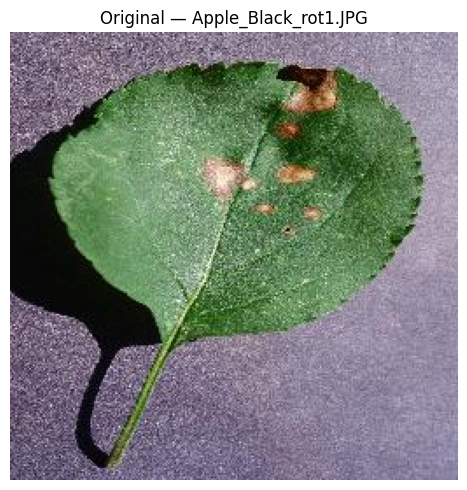

In [11]:
if IMAGE_PATH is None:
    print("Skipping: set IMAGE_PATH to a valid image path (and ensure the model is loaded above).")
    img_rgb = None
else:
    img_bgr = cv2.imread(str(IMAGE_PATH))
    if img_bgr is None:
        print(f"Could not load image: {IMAGE_PATH}")
        img_rgb = None
    else:
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        print(f"Loaded: {IMAGE_PATH}")
        print(f"Shape: {img_rgb.shape}")
        plt.figure(figsize=(6, 5))
        plt.imshow(img_rgb)
        plt.title(f"Original — {IMAGE_PATH.name}")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

---
## 4. Augmentations

The same **augmentation pipeline** used when balancing the training set (rotation, blur, contrast, scaling, illumination, perspective) can be applied here for visualization. We use the image loaded above and display original + augmented variants in a grid.

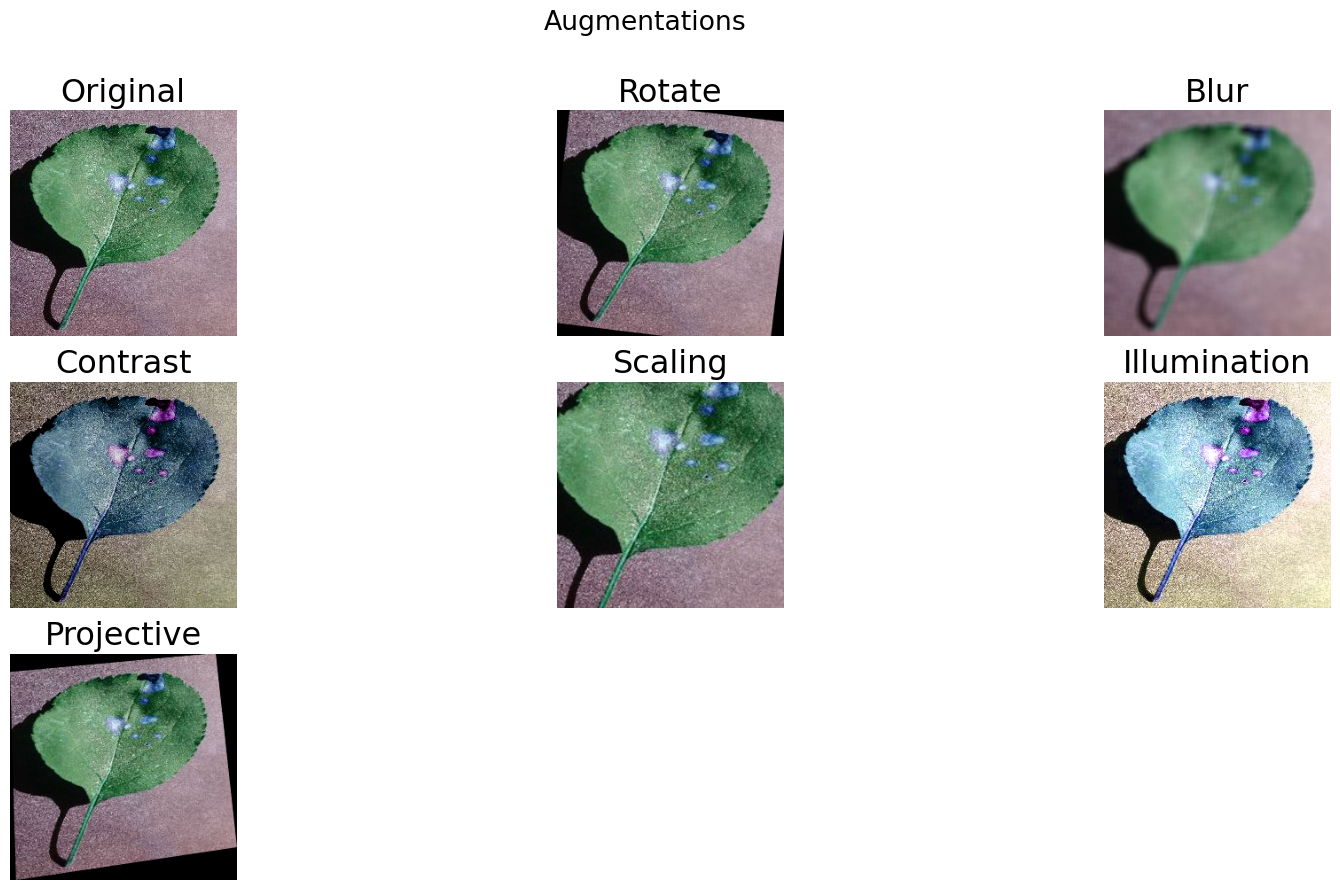

In [12]:
from leaffliction.augmentations import AugmentationEngine
from leaffliction.plotting import Plotter

if img_rgb is None:
    print("Skipping: load an image in section 3 first.")
else:
    engine = AugmentationEngine()
    results = engine.apply_all_script(img_rgb)
    grid = Plotter()
    grid.plot_grid("Augmentations", results, original=img_rgb)

---

## 5. Preprocess & transforms

The model expects a **multi-channel input** built by the project's **TransformationEngine** (training preset):

- **Hue** — hue channel to emphasise colour information relevant to disease.
- **Masked** — leaf mask (background removed) to focus on the leaf region.
- **AnalyzeImage** — plantcv-based analysis view.
- **PseudoLandmarks** — pseudo-landmark representation.

Each transform produces one channel; they are stacked into a tensor of shape `(1, C, H, W)` with `C=4`. The image is resized to **config.img_size** (e.g. 224×224) before applying transforms.

Input tensor shape: torch.Size([4, 224, 224])
Transforms: ['Hue', 'Masked', 'AnalyzeImage', 'PseudoLandmarks']


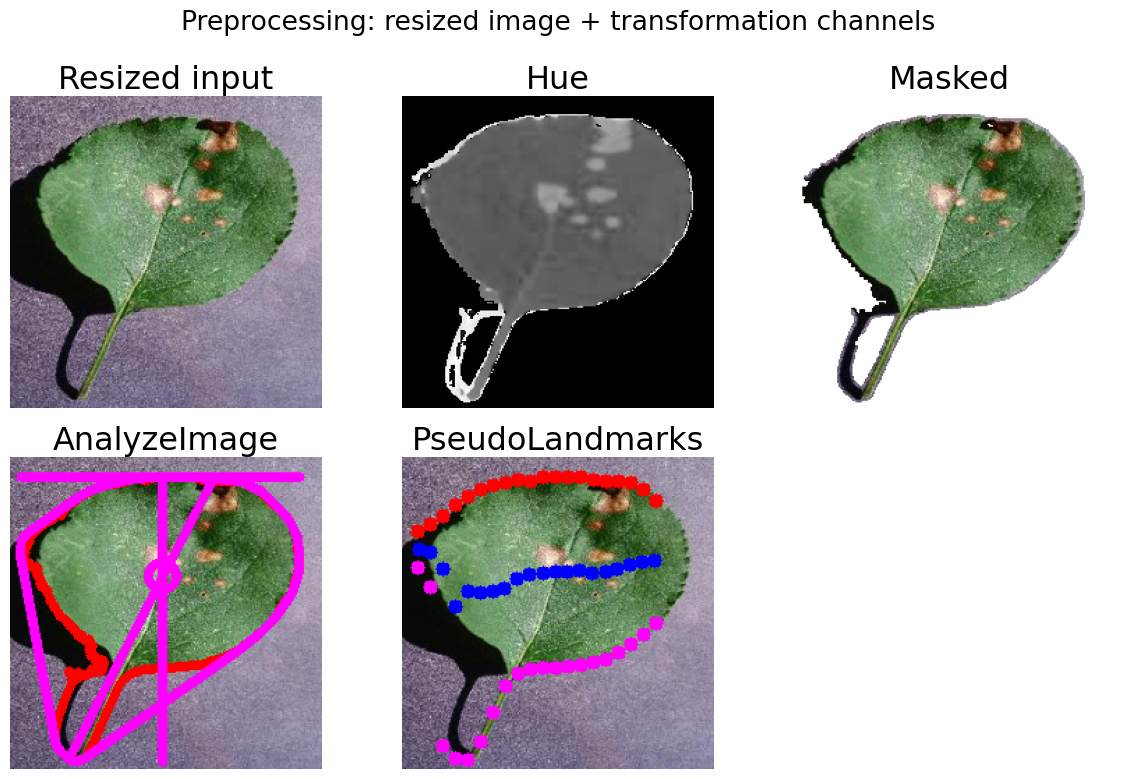

In [13]:
if loader is None or img_rgb is None:
    print("Skipping: load model and image first.")
    tensor = None
    transformed_imgs = None
else:
    transformation_engine = TransformationEngine.trainning(verbose=False)
    img_size = loader.cfg.img_size
    img_resized = cv2.resize(img_rgb, img_size)

    tensor = transformation_engine.apply_all_as_tensor(img_resized)
    transformed_imgs = transformation_engine.apply_all(img_resized)

    print(f"Input tensor shape: {tensor.shape}")
    print(f"Transforms: {list(transformed_imgs.keys())}")

    # Visualise original + transformed channels
    n = 1 + len(transformed_imgs)
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
    axes = axes.flatten() if n > 1 else [axes]
    axes[0].imshow(img_resized)
    axes[0].set_title("Resized input")
    axes[0].axis("off")
    for i, (name, arr) in enumerate(transformed_imgs.items(), start=1):
        ax = axes[i] if i < len(axes) else None
        if ax is not None:
            if arr.ndim == 3:
                ax.imshow(arr)
            else:
                ax.imshow(arr, cmap="gray")
            ax.set_title(name)
            ax.axis("off")
    for j in range(len(transformed_imgs) + 1, len(axes)):
        axes[j].axis("off")
    plt.suptitle("Preprocessing: resized image + transformation channels")
    plt.tight_layout()
    plt.show()

---

## 6. Predict

We pass the preprocessed tensor to the loaded model. The model outputs **logits**; we apply **softmax** to get class probabilities and take **argmax** for the predicted class (same logic as `InferenceManager.predict` in `leaffliction/model.py`).

In [14]:
if loader is None or tensor is None:
    print("Skipping: load model and run preprocessing first.")
    predicted_label = None
    probs = None
else:
    pred_id, probs = loader.predict(tensor)
    predicted_label = loader.labels.decode(pred_id)
    print(f"Predicted class: {predicted_label}")
    print(f"Confidence: {probs.get(predicted_label, 0):.2%}")

Predicted class: Apple_Black_rot
Confidence: 100.00%


---

## 7. Interpret

**Top-k** predictions (same as CLI `--top-k`): we sort classes by probability and show the top ones. The project does not output a confusion matrix or classification report in this notebook; those are produced when running `predict.py --dir-path` on a labelled directory.

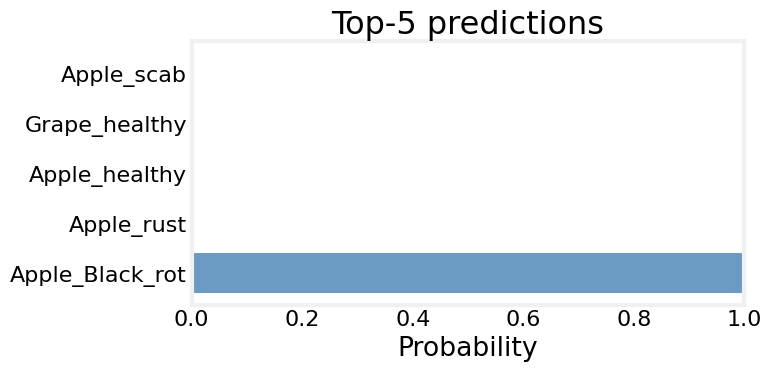

Top-k probabilities:
  1. Apple_Black_rot: 100.00%
  2. Apple_rust: 0.00%
  3. Apple_healthy: 0.00%
  4. Grape_healthy: 0.00%
  5. Apple_scab: 0.00%


In [15]:
TOP_K = 5

if probs is None:
    print("No predictions to show.")
else:
    sorted_probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:TOP_K]
    labels_top = [x[0] for x in sorted_probs]
    values_top = [x[1] for x in sorted_probs]

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.barh(range(len(labels_top)), values_top, color="steelblue", alpha=0.8)
    ax.set_yticks(range(len(labels_top)))
    ax.set_yticklabels(labels_top)
    ax.set_xlabel("Probability")
    ax.set_title(f"Top-{TOP_K} predictions")
    ax.set_xlim(0, 1)
    plt.tight_layout()
    plt.show()

    print("Top-k probabilities:")
    for i, (label, p) in enumerate(sorted_probs, 1):
        print(f"  {i}. {label}: {p:.2%}")

---

## 8. Appendix: metrics & limitations

### Problem & classes

**Leaffliction** classifies plant leaf images into **8 classes** (Apple/Grape diseases and healthy): Apple_Black_rot, Apple_healthy, Apple_rust, Apple_scab, Grape_Black_rot, Grape_Esca, Grape_healthy, Grape_spot.

### Data assumptions

- **Input:** RGB image; formats supported by OpenCV (JPG, PNG, etc.).
- **Preprocessing:** Resize to `img_size` (e.g. 224×224), then the same 4 transforms as in training (Hue, Masked, AnalyzeImage, PseudoLandmarks) to build a 4-channel tensor. No extra normalisation is applied in the transform output (values in [0,1] per channel).

### Model overview

Architecture (from `leaffliction/model.py` — **ConvolutionalNeuralNetwork**):

- **Features:** 4 blocks of `Conv2d → ReLU → MaxPool2d` (channels 32 → 64 → 128 → 256), then **AdaptiveAvgPool2d(1)** (GAP).
- **Classifier:** Flatten → Linear(256, 128) → ReLU → Dropout(0.5) → Linear(128, num_classes).
- **Output:** Logits; softmax gives class probabilities.

### How metrics were produced in the project

- **Train/valid accuracy** and **loss** are computed in `leaffliction/train_pipeline.py` (per-epoch and final). Validation accuracy must be ≥ 90% and validation set size ≥ 100 (ModelChecker).
- **Directory accuracy** (e.g. on `test_images/100`): when running `predict.py --dir-path <dir>`, the script infers ground truth from folder/filename and reports correct/total and accuracy. No confusion matrix or classification report is computed in the repo; those could be added as a next step.

### Example commands & outputs

Below are **bash examples** and **sample terminal outputs** so you can see what to expect when running the scripts from the repo root (with `conda activate tf` or the project env).

**Distribution (class counts):**
```bash
python Distribution.py ./leaves/images --mode both --save . --verbose
```
*Output:* Plots (pie/bar) of class distribution; optional PNG saved to `--save` path.

**Augmentation (single image, grid + save):**
```bash
python Augmentation.py "./leaves/images/Apple_Black_rot/image (100).JPG" --output-dir augmented_directory --verbose
```
*Output:* A window with the grid (Original + Rotate, Blur, Contrast, Scaling, Illumination, Projective); augmented images saved under `augmented_directory/`.

**Transformation (single image or batch):**
```bash
python Transformation.py "./test_images/Unit_test1/Apple_Black_rot1.JPG" --only hue mask analyze pseudo --verbose
python Transformation.py --src ./leaves/images --dst ./training_artifacts/transform --verbose
```
*Output:* Visualisation of transformed channels and/or saved images under `--dst`.

**Training (full pipeline; heavy):**
```bash
python train.py ./leaves/images --out-dir training_artifacts --out-zip train_output.zip --verbose
```
*Example output (excerpt):*
```
Epoch 1/70 — Train Acc: 19.38%, Valid Acc: 28.02%
...
Epoch 35/70 — Train Acc: 98.00%, Valid Acc: 96.46%
Epoch 70/70 — Train Acc: 98.91%, Valid Acc: 96.88%
Final (best checkpoint): Train 99.98%, Valid 98.06%, ~717 s
```
Model artifacts: `training_artifacts/model/` (config.json, labels.json, model.pth) and `train_output.zip`. Learning curves: `learning curve.jpg`, `learning curve_loss.jpg`. For headless: `MPLBACKEND=Agg python train.py ./leaves/images`.

**Prediction (single image):**
```bash
python predict.py --model-path ./worked/model ./test_images/Unit_test1/Apple_Black_rot1.JPG
```
*Example output:*
```
Predicted class: Apple_Black_rot
Top-3: Apple_Black_rot 0.98, Apple_rust 0.01, Apple_scab 0.00
```

**Prediction (directory; accuracy summary):**
```bash
python predict.py --model-path ./worked/model --dir-path ./test_images/100 --verbose
```
*Example output:*
```
Correct: 143 / 152
Accuracy: 94.08%
```
The 10 images in `test_images/Unit_test1` and `test_images/Unit_test2` are the project’s unit-test set; the model in `./worked/model` is expected to predict them correctly.

### Limitations & next steps

- This notebook does **not** train; it only runs inference.
- Model must be present under `worked/model/` (or set `MODEL_DIR` and load manually).
- Transforms depend on **plantcv** and **rembg**; some images may fail in edge cases.
- For batch evaluation and accuracy on a folder, use the CLI: `python predict.py --model-path ./worked/model --dir-path <dir> --verbose`.
- Possible extensions: confusion matrix, classification report, export of predictions to CSV.